<h1><center>Learning Universal Parameters with Machines:</center></h1>
<h1><center>An Exploration of the CAMELS Multifield Dataset</center></h1>

<h3><center>Sam English</center></h3>
<center>June 1, 2022</center>

<h2><b></b> Acknowledgments</h2>

I'd like to thank my senior thesis for consuming my life outside of this project. \
I'd also like to thank my cat.

ReadMe.txt contains more information about this notebook. \
Links to download data are available at https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/ if necessary.

***

<h2><b>Section 1.</b> Introduction to CAMELS Multifield Dataset

>``You are the universe, expressing itself as a human for a little while.'' <em>—Eckhart Tolle</em>

<justify> As a manifestation of the larger universe, it is astounding that we are capable of asking such questions as to the nature of life, the birth of our universe, the fundamental parameters governing the dynamical interplay between energy and matter. 



<justify> Our story begins with curiosity, the want to understand why nature chose certain values of cosmological parameters over any other. 



<justify> The CAMELS Multifield Dataset (CMD) has been generated from thousands of magneto-hydrodynamic and gravity-only N-body simulations taken from the original CAMELS (Cosmology and Astrophysics with MachinE Learning Simulations) project.

***

<h2><b>I.</b> Data Classification

>We can classify the CMD data into three distinct groups:
- <b>IllustrisTNG</b>. These magneto-hydrodynamic simulations evolve gas, black-holes, stars, and dark matter (includes magnetic fields; 15,000 2D maps for each of 13 fields).

- <b>SIMBA</b>.  Hydrodynamic simulations following evolution of gas, black-holes, stars, and dark matter (15,000 2D maps for each of 12 fields).
- <b>N-body</b>. Gravity-only N-body simulation follows the evolution of dark matter (30,000 2D maps for each of one field).

>Respectively, these each contain some large amount of 2D maps and 3D grids containing information. \
All 2D maps have $256^2$ pixels and cover a periodic area of $(25 \textrm{ h}^{-1}\textrm{Mpc})^2$ at redshift 0. \
The 3D grids contain $128^3$, $256^3$ or $512^3$ voxels over a volume of $(25 \textrm{ h}^{-1}\textrm{Mpc})^3$ and are at reshifts 0, 0.5, 1, 1.5, and 2.

In total, we essentially have access to twelve distinct fields to examine our data: <span style="color:red">gas density, <span style="color:orange">gas velocity, <span style="color:yellow">gas temperature, <span style="color:green">gas pressure, <span style="color:dodgerblue">dark matter density, <span style="color:fuchsia">dark matter velocity, <span style="color:hotpink">electron number density, <span style="color:lightsalmon">magnetic fields, <span style="color:mediumorchid">stellar mass density, <span style="color:olivedrab">neutral hydrogen mass density, <span style="color:sandybrown">gas metallicity, <span style="color:yellowgreen">and magnesium over iron ratio.

These images show the different properties of stars, dark matter, and gas in a given universe with a given set of cosmological parameters. Determining the value of those parameters from these images will aid us in the ultimate quest to decode the true value within our own universe, allowing us to unravel some of the greatest mysteries of our time.

<h2><b>II.</b> Methods & Implementation

The approach for this large set of data will have to be carefully crafted: my personal computer is limited by storage space as well as computational resources.

<b>First and foremost</b>, I will be neglecting the 3D grid data from CMD for the purposes of this project. While it would be fun to analyze everything in detail, some sacrifices must be made for the sake of reducing complexity for an entry-level machine learning project.

We are told that each pixel of a 2D is stored as a float (occupies 4 bytes) <span style="color:dodgerblue">[1].</span> Thus, a single 2D map with $256^2$ pixels will take up roughly 0.25 Mb of space. CMD is organized into files that contain 15,000 maps per field. These files require 3.75 Gb. Since there are 27 of those files in CMD (13 for IllustrisTNG, 12 for SIMBA, and 1+1 for N-body), downloading everything requires around 100 Gb.

<h3>Symmetries</h3>

Each 2D map has a set of labels associated to it: two cosmological parameters and four astrophysical parameters. These labels will remain the same if we perform any set of rotations, translations, or parity operations to our data. When using convolutional neutral networks, I can take advantage of this property via periodic padding, etc. 

Fortunately, this problem has been tackled previously: thus, I have a guiding light towards what I can potentially accomplish with my neural network! I suspect the architecture of <b>my model will consist of a set of convolutional layers (CNNs) followed by a fully connected layer.

<h3>Previous Problems in the Literature</h3>

The architecture explained in <span style="color:dodgerblue">[2]</span> have some limitations:
- Is there a better model to constrain parameter values with higher accuracy?

- How do we address training the models using IllustrisTNG, for example, and then getting less than stellar results when testing on SIMBA maps?
- What is the minimum set of fields of a multifield that contain at least 90\% of the cosmological and astrophysical information?

<h2>References

[1]
https://camels-multifield-dataset.readthedocs.io/en/latest/data.html 

[2]
https://arxiv.org/pdf/2109.10915v1.pdf 

[3]
https://www.sdss.org/science/data-release-publications 


***

<h1><center>Python Playground</center></h1>

***
***

<h2><b>Section 2.</b> Imports and Data Cleaning

***

## Library Imports
 >Let's Import all the libraries we'll need:

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

import torch
import torch.nn
import torch.nn as nn
import torch.nn.functional
import torch.nn.functional as F
import torch.optim
import torch.utils.data

import torch.backends.cudnn as cudnn
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import time, sys, os

if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
else:
    print('CUDA Not Available')
    device = torch.device('cpu')
cudnn.benchmark = True      #May train faster but cost more memory

CUDA Available


## Data I/O
>Now, let's go ahead and access the data. \
>As of this cell, we're taking two fields for the SIMBA simulations (cold dark matter mass, "normal" matter gas velocity) and importing them:

In [3]:
# Name of the file accessed.

fmaps = 'Maps_Mcdm_SIMBA_LH_z=0.00.npy'
    # SIMBA simulation,
    # Mass of cold dark matter sub-field,
    # Latin-Hypercube method of generating associated cosmological parameters,
    # Redshift z=0.00.

fmaps2 = 'Maps_Vgas_SIMBA_LH_z=0.00.npy'
    # SIMBA simulation,
    # Velocity of gaseous matter sub-field,
    # Latin-Hypercube method of generating associated cosmological parameters,
    # Redshift z=0.00.


# Read the file from it's `fmaps` path:
maps  = np.load(fmaps)
maps2  = np.load(fmaps2)

> Now that we have access to the images (2D maps), let's obtain the associated cosmological parameters which created them:

In [4]:
# Load the parameters .txt file associated with our SIMBA 2D map simulation:
params = np.loadtxt('params_SIMBA.txt')

# Let's display the shapes of each of these imported files (images and parameters):
print(np.shape(params)) # 6 parameters x 1000 in length. Each row entry relates to a set of 15 2D maps.
print(np.shape(maps))   # 15000 2D simulation maps of size 256x256.

(1000, 6)
(15000, 256, 256)


>**Great!** We've imported both the simulation data and cosmological parameters for a small subset of the larger CMD dataset. \
> Let's take a closer look at an individual 2D map from our `maps` stored variable:

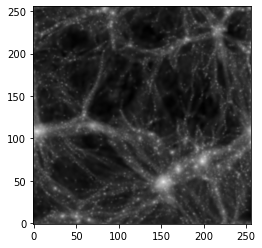

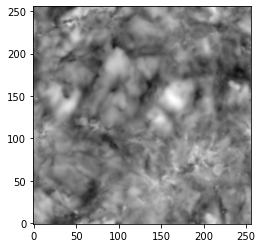

Value of the parameters for this map
Omega_m: 0.37940
sigma_8: 0.89860
A_SN1:   0.54261
A_AGN1:  1.02669
A_SN2:   0.76049
A_AGN2:  0.91573


In [5]:
# Take a random map_number to inspect:
map_number = np.random.randint(0,len(maps))

# Get associated parameters (sort by groups of 15 via floor division).
params_map = params[map_number//15]

# Plot np.log10(image) to see what's going on, visually!
plt.imshow(np.log10(maps[map_number]),cmap=plt.get_cmap('binary_r'), origin='lower', interpolation='bicubic')
plt.show()
plt.imshow(np.log10(maps2[map_number]),cmap=plt.get_cmap('binary_r'), origin='lower', interpolation='bicubic')
plt.show()

# Now, we can easily print the associated parameters which fed into the creation of this simulated 2D map.
print('Value of the parameters for this map')
print('Omega_m: %.5f'%params_map[0])
print('sigma_8: %.5f'%params_map[1])
print('A_SN1:   %.5f'%params_map[2])
print('A_AGN1:  %.5f'%params_map[3])
print('A_SN2:   %.5f'%params_map[4])
print('A_AGN2:  %.5f'%params_map[5])

> ### Let's see if we can generalize this for *any* amount of simulated maps in our dataset:

## Cold Dark Matter Mass ($\textrm{M}_{\textrm{cdm}}$) plots

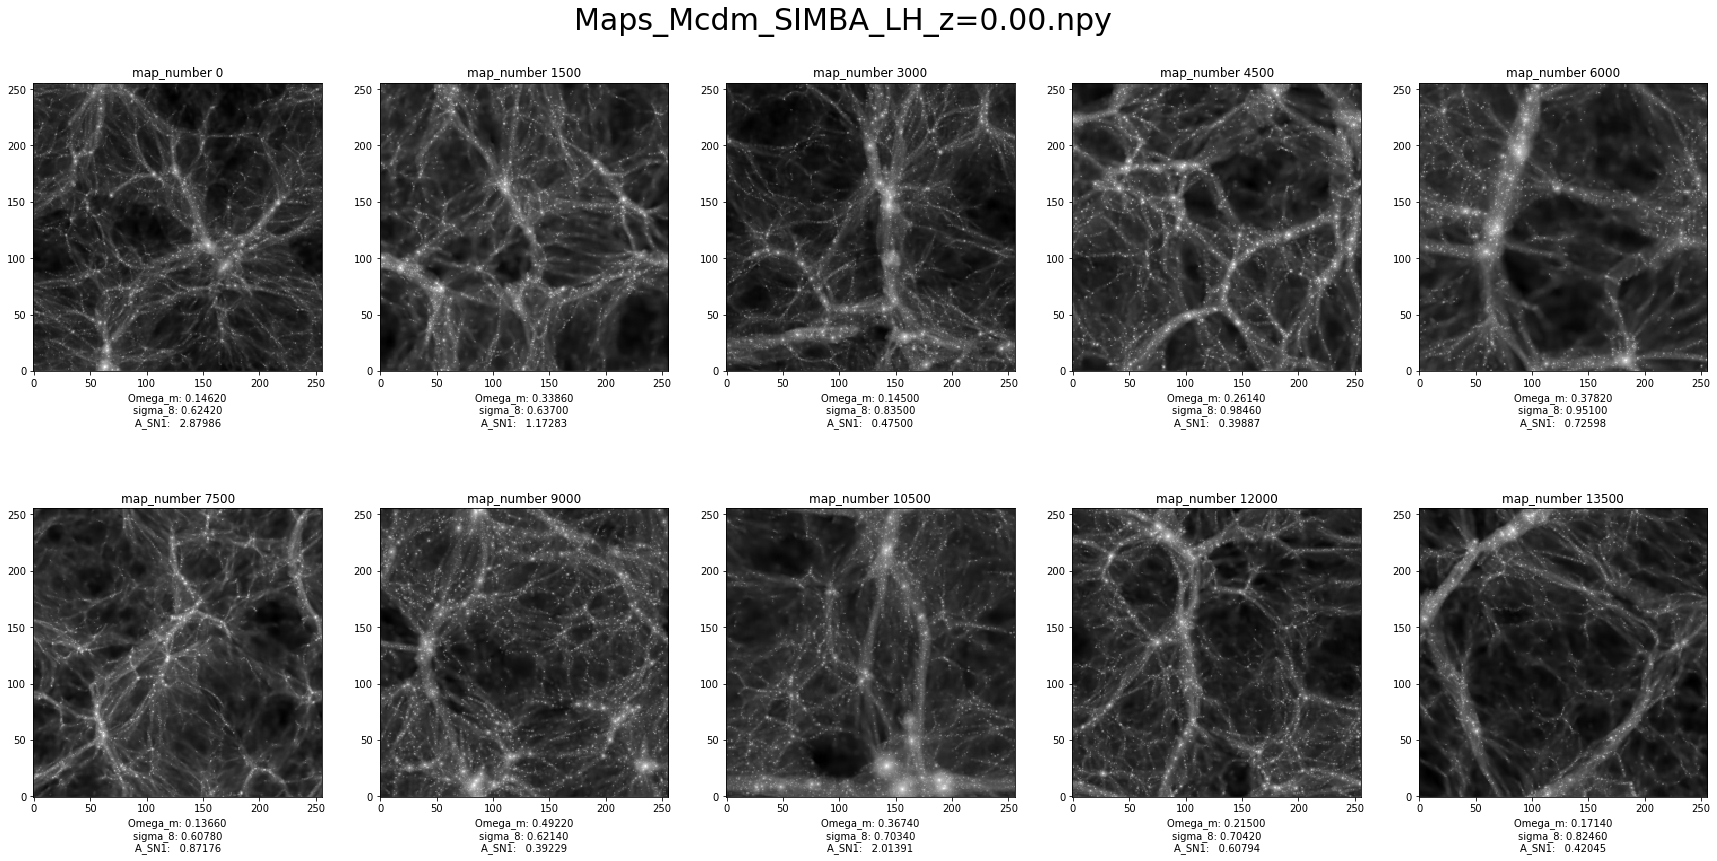

In [6]:
fig1 = plt.figure(figsize = (30,30)) # Create a large figure for display.
fig1.suptitle(fmaps,fontsize=30,y=0.9)
numb = 10 # Number of maps to display below.

i=0 # Running sum index.
for index, item in enumerate(maps): # Loop through each 256x256 map.
    if index % (len(maps)/numb) == 0: 
        map_number = index
        params_map = params[map_number//15] # Each set of 15 maps corresponds to the same set of cosmological parameters.

        i+=1
        ax1 = fig1.add_subplot(4,5,i) # Create axis to place subplot on.
        ax1.imshow(np.log10(maps[index]),cmap=plt.get_cmap('binary_r'), origin='lower', interpolation='none') # Display 2D map of CDM mass.
        ax1.set_xlabel('Omega_m: %.5f\n'%params_map[0] + # Set labels for cosmological parameters (first 3 entries of 6).
                       'sigma_8: %.5f\n'%params_map[1] +
                         'A_SN1:   %.5f'%params_map[2]
                    )
        ax1.set_title('map_number %g'%map_number)

<h3>These almost look like mycelium networks (or even neurons) 🤯

## Gaseous Matter Velocities ($\textrm{V}_{\textrm{gas}}$) plots

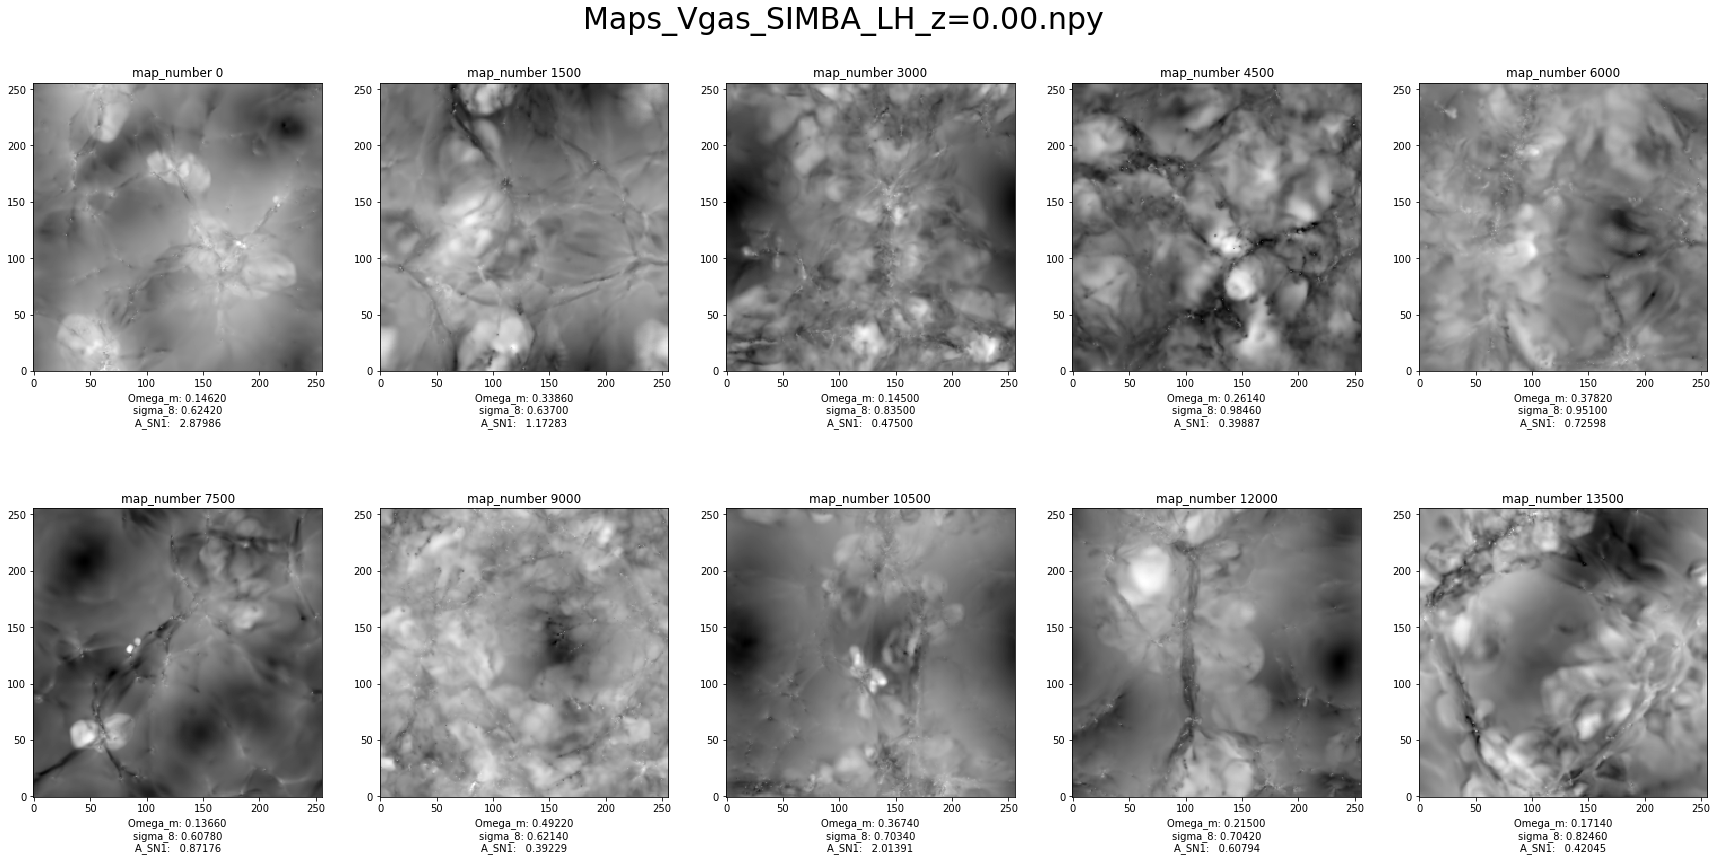

In [7]:
fig1 = plt.figure(figsize = (30,30)) # Create a large figure for display.
fig1.suptitle(fmaps2,fontsize=30,y=0.9)
numb = 10 # Number of maps to display below.

i=0 # Running sum index.
for index, item in enumerate(maps2): # Loop through each 256x256 map.
    if index % (len(maps2)/numb) == 0: 
        map_number = index
        params_map = params[map_number//15] # Each set of 15 maps corresponds to the same set of cosmological parameters.

        i+=1
        ax1 = fig1.add_subplot(4,5,i) # Create axis to place subplot on.
        ax1.imshow(np.log10(maps2[index]),cmap=plt.get_cmap('binary_r'), origin='lower', interpolation='none') # Display 2D map of Vgas.
        ax1.set_xlabel('Omega_m: %.5f\n'%params_map[0] + # Set labels for cosmological parameters (first 3 entries of 6).
                       'sigma_8: %.5f\n'%params_map[1] +
                         'A_SN1:   %.5f'%params_map[2]
                    )
        ax1.set_title('map_number %g'%map_number)

<h3>Amazing, looks like we've gained a good handle on the data, formatting, and plotting!</h3>

> Let's move on to deciding on a network architecture to use and then impliment it.

***

<h2><b>Section 3.</b> Network Construction

***

Between all of the autoencoders, fully-connected networks, and restricted boltzmann machines that we've covered in this course, I opt to construct a convolutional neural network (CNN, with pooling) with a few fully-connected layers feeding into an MSE loss estimation for a single parameter.

CNN's are extremely efficient (when made correctly) at performing prediction, identification, etc. with large datasets containing high complexity from the sheer amount of pixels a given image may have.

<h3> Factors affecting efficiency:</h3>

>- <b>Filters</b>:
Each layer of the CNN may be applied to the filters and mapped onto images to create some result. These filters are able to detect unique features from the images: many of these, stacked, helps to create our first convolutional layer.

>- <b>Kernel Size</b>:
Affects efficiency and performance of the our CNN model. 

>- <b>Padding</b>:
Grants extra room to the kernel, adding an extra frame to the sides of the input image such that our result does not unnecessarily decrease in accuracy or efficiency.

>- <b>Stride</b>:
The number of pixels we shift over the information network: the distance to move, filter, moving faster with larger values. 


<h3> CNN Architecture</h3>

Ideally, we'll construct something along these lines:

>- <b>Convolutional Layer</b>:
Backbone of our CNN. This layer scans images, pixel by pixel, and creates feature maps to define future classifications/predictions.

>- <b>Pooling Layer</b>:
Down-sampling of data to keep only the most necessary data from images. This process of creating convolutional layers and pooling is continuous (may loop several times).

>- <b>Fully-connected Input Layer</b>:
Flattening of the images. The outputs gained from above are taken to be a single vector, prepared for the next layer.

>- <b>Fully-connected Layer</b>:
After feature analysis, this layer assigns random weights to inputs and makes predictions.

>- <b>Fully-connected Output Layer</b>:
Contains the results of the labels or values for prediction and assigns a value for the parameter of interest.


> ## Prepare Images for Training 

> Every set of 15 maps contains identical parameters, but different initial condition seeds for simulation.

> Let's train on half of the images we've already accessed (for a mix of two sub-fields in the SIMBA simulation maps), and test them on the remaining half. \
> Once we're comfy, we can then expand to other fields and incorporate other factors into training!

In [8]:
j=0
cmaps = []
for i in range(len(maps)): 
    if i%15 == 0:                     # Take only a single simulation per set of parameters.
        if np.random.randint(0,1)==1: # randomly sample either Mcdm OR Vgas!
            j+=1
            cmaps.append(maps2[i])    # Vgas
        else:
            j+=1
            cmaps.append(maps[i])     # Mcdm

n_train  = len(cmaps) //5             # take only ~100 of the total 1000 images provided (for computational efficiency).
n_split  = n_train    //2
    # Split data into training and testing samples.

img_train = cmaps[:n_split]
img_test  = cmaps[n_split:n_train]
    # now we have two sets of data to use!

print("Now we have an image train and test set of lengths", len(img_train), "and", len(img_test))

Now we have an image train and test set of lengths 100 and 100


> ## Normalize the data:

In [9]:
print("Training images shape:",np.shape(img_train))
x_train=np.asarray(img_train) # convert to numpy array.
print('\n')

print("Testing images shape:",np.shape(img_test))
x_test=np.asarray(img_test) # convert to numpy array.
print('\n')

    # normalize cosm. and astro. params 
    # (min/max taken from CMD documentation):
minimum = np.array([0.1, 0.6, 0.25, 0.25, 0.5, 0.5])
maximum = np.array([0.5, 1.0, 4.00, 4.00, 2.0, 2.0])
params  = (params - minimum)/(maximum - minimum)


y_train, y_test = params[:n_split], params[n_split:n_train]
    # Takes only the *first* cosmological parameters, for now.
y_train = np.asarray(y_train[:,0])
y_test  =  np.asarray(y_test[:,0])

print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)



print('\n---------------\n')
print('What are the image values for individual pixels?')
print(x_train[0][0][0])
print(x_test[0][0][0])
print('Very large.\n')

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

    # Normalize the images that we have 
    # (the brightness values for Mcdm/Vgas):
for index,image in enumerate(x_train):
    scaler.fit(image)
    image = scaler.transform(image)
    x_train[index] = image

for index,image in enumerate(x_test):
    scaler.fit(image)
    image = scaler.transform(image)
    x_test[index] = image

print('\n---------------\n')
print('Do these normalized image values look reasonable?')
print(x_train[0][0][0])
print(x_test[0][0][0])
print('Yes, they do now.\n')

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

print('max y_train parameter value: {%f}, min y_train val: {%f}' % (max(y_train),min(y_train)))
print('max y_test parameter value: {%f}, min y_test val: {%f}' % (max(y_test),min(y_test)))

Training images shape: (100, 256, 256)


Testing images shape: (100, 256, 256)


y_train shape: (100,)
y_test shape: (100,)

---------------

What are the image values for individual pixels?
99547790000.0
87912610000.0
Very large.


---------------

Do these normalized image values look reasonable?
0.16266993
0.044500843
Yes, they do now.

y_train shape: (100,)
y_test shape: (100,)
max y_train parameter value: {0.994500}, min y_train val: {0.004500}
max y_test parameter value: {0.998500}, min y_test val: {0.010500}


> Above, we saved two sets of image data for x_tensors (both train and test), as well as two y_tensors containing only a `single` cosmological parameter, for now. \
> All data has been normalized so to please our CNN as it does its best to compute.

>  ## Prepare data tensors:

> Need to unsqueeze them to ensure the format of the `torch.tensor` objects are able to fit into our CNN!

In [10]:
# X_TRAIN TENSOR
x_train_tensor=torch.tensor(x_train,dtype=torch.float)
print("x_train tensor:",x_train_tensor.shape)
x_train_tensor=x_train_tensor.unsqueeze(1)
print("x_train tensor unsqueezed:",x_train_tensor.shape)
x_train_tensor=x_train_tensor.float()
print('\n')

# Y_TRAIN TENSOR
y_train_tensor=torch.tensor(y_train,dtype=torch.float)
print("sigma_m y parameter tensor:",y_train_tensor.shape)
y_train_tensor=y_train_tensor.unsqueeze(1)
y_train_tensor=y_train_tensor.float()

# X_TEST TENSOR
x_test_tensor=torch.tensor(x_test,dtype=torch.float)
x_test_tensor=x_test_tensor.unsqueeze(1)
x_test_tensor=x_test_tensor.float()

# Y_TEST TENSOR
y_test_tensor=torch.tensor(y_test,dtype=torch.float)
y_test_tensor=y_test_tensor.unsqueeze(1)
y_test_tensor=y_test_tensor.float()


xy_train = torch.utils.data.TensorDataset(x_train_tensor.float(),y_train_tensor)

x_train tensor: torch.Size([100, 256, 256])
x_train tensor unsqueezed: torch.Size([100, 1, 256, 256])


sigma_m y parameter tensor: torch.Size([100])


## CNN Architecture

> ### Define CNN network:

> Taken as foundational case from in-class `CNN.ipynb`. \
> Let's just throw spaghetti at the wall and see what sticks!

In [44]:
torch.manual_seed(123)
class Net(torch.nn.Module): # define our network!
    def __init__(self, conv_layer_size=16, linear_layer_size=32):
        super(Net, self).__init__()

        lls=linear_layer_size # take from init input.
        cls=conv_layer_size   # ...

        image_size = 1
        
        # CLASStorch.nn.Conv2d(in_channels, out_channels, kernel_size, \
        # stride=1, padding=0, dilation=1, groups=1, bias=True, 
        # padding_mode='zeros', device=None, dtype=None)
        self.conv1 = torch.nn.Conv2d(  image_size, image_size*16, kernel_size=3, padding=1,stride=2)
        self.conv2 = torch.nn.Conv2d(image_size*16, image_size*32, kernel_size=3, padding=1,stride=2)
        self.conv3 = torch.nn.Conv2d(image_size*32, image_size*64, kernel_size=3, padding=1,stride=2)

        # fully connected layer(s)
        self.fc1 = torch.nn.Linear(image_size*64, image_size*2)
        self.fc2 = torch.nn.Linear(image_size*2, 1)
        
        # dropout layer
        self.dropout = torch.nn.Dropout2d(0.3)

    # x represents our data
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)

        # if we wanted to add another layer before pooling, we could do that here.

        # Run max pooling over x, (input, kernel_size).
        x = F.max_pool2d(x, 1)
        
        # we could also do some dropout here if we wanted!!
        x = self.dropout(x)

        x = self.conv2(x)
        x = F.relu(x)

        x = F.max_pool2d(x, 1)

        x = self.dropout(x)

        x = self.conv3(x)
        x = F.relu(x)

        # the (1,1) makes this into global average pooling
        x = F.adaptive_avg_pool2d(x,(1,1))
    
        # Flatten x with start_dim=1, i.e. only keep one number per channel per event.
        # This one line kept me up into the wee hours the other night!
        x=torch.flatten(x,1) # (input, start_dim (first dim to flatten))
      
        # Pass data through the fully connected layer(s).
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        return x

***

<h2><b>Section 4.</b> Parameters, Optimizer, & Loss Function

***

> #### Initialize CNN `Net()`, and impliment `optimizer` along with `loss_fn`

> Hearing from others who have conducted similar projects, `torch.optim.SGD()` seems like a good starting place for our CNN.

In [45]:
    # create the net, define the loss fuction and optimizer
net = Net()

print(net)
print(np.sum([np.prod(theta.shape) for theta in net.parameters()]))

optimizer = torch.optim.SGD(net.parameters(), lr=0.3, momentum=0.9,weight_decay=1e-6) 
    # Stochastic Gradient Descent (SGD) optimizer.
    # starting with a modest, but high, learning rate of 0.3
    # large momentum of 0.9,
    # small weight_decay of 1e-6.
    
loss_fn = torch.nn.MSELoss() 
    # MSE loss is pretty standard for predicting a numerical value from our network.

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (fc1): Linear(in_features=64, out_features=2, bias=True)
  (fc2): Linear(in_features=2, out_features=1, bias=True)
  (dropout): Dropout2d(p=0.3, inplace=False)
)
23429


> Tiny in terms of no. of parameters! 

> Realistically, we don't expect this network to produce anything meaningful, since we've ripped it from the lecture notes without changing anything to fit our own problem's context.

***

<h2><b>Section 5.</b> Execution

***

> #### Let's now train the computer to predict some <span style="font-family:Papyrus; font-size:2em;"><span style="color:red">cosmological parameters!

In [51]:
net.train()
losses      = []
losses_test = []
    # initialize net() + loss arrays.
    
    # feed in our data, set batch_size =/= 0 s.t. wall time decreases.
loader = torch.utils.data.DataLoader(xy_train, batch_size=5, shuffle=True)

    # loop over 100 epochs to begin with!
for epoch in tqdm(range(100)):
    start_time = time.time()
    for x_batch, y_batch in loader:
        y_pred = net(x_batch)
        optimizer.zero_grad()
        loss   = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    losses.append(loss.data)
    
        # configure the model for evaluation (testing)
    net.eval() 
    y_pred       = net(x_test_tensor)
    test_loss    = loss_fn(y_pred, y_test_tensor)
    losses_test.append(test_loss.data)
    end_time     = time.time()
    elapsed_time = end_time - start_time
    # print("Completed epoch %2d in %4.1fs, Train loss=%4.1e, Test loss=%4.2e" % (epoch, elapsed_time, loss.data, test_loss.data))

100%|██████████| 100/100 [03:04<00:00,  1.85s/it]


> Let's now take a gander at the MSE loss cureves for training and testing!

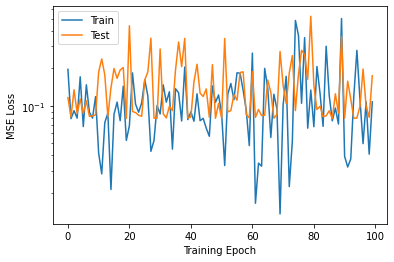

In [52]:
plt.plot(losses, label="Train")
plt.plot(losses_test, label="Test")
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('MSE Loss')
plt.yscale('log');

> This looks pretty miserable, as expected.
> There's a bit of overtraining, but everything is so noisy that we can't really say anything certain. 

> Extending the run-time would most likely not help.

> No notable results can really be produced from this: we'd also expect any predictions to be nonsense.


***

<h2><b>Section 6.</b> Results

***

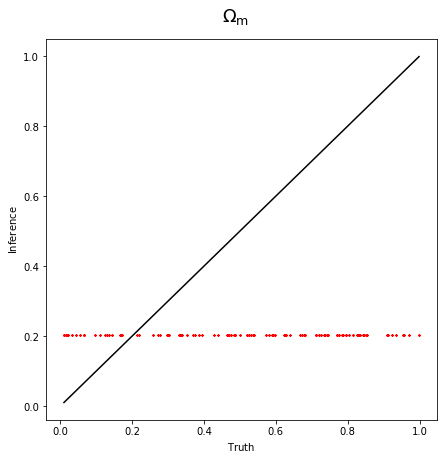

In [74]:
    # create an inference vs. truth plot.
fig=plt.figure(figsize=(7,7))
plt.xlabel(r'${\rm Truth}$')
plt.ylabel(r'${\rm Inference}$')
# plt.ylim(0,1)
plt.text(0.45, max(y_test)+0.10, r'$\Omega_{\rm m}$',fontsize=18)

    # compare predicted values with the y_test values!
plt.scatter(y_test, y_pred[:,0].detach().numpy(), color='r',marker='x',s=3)
plt.plot([min(y_test),max(y_test)], [min(y_test),max(y_test)], color='k')
 
plt.show()

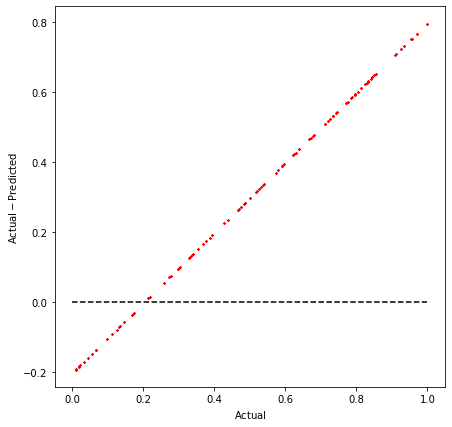

In [80]:
    # create an inference vs. truth plot.
fig=plt.figure(figsize=(7,7))
plt.xlabel(r'${\rm Actual}$')
plt.ylabel(r'${\rm Actual-Predicted}$')

    # compare predicted values with the y_test values!
plt.scatter(y_test, (y_test - y_pred.detach().numpy()[:,0]), color='r',marker='x',s=3)
plt.plot([0,1], [0,0], 'k--')
 
plt.show()

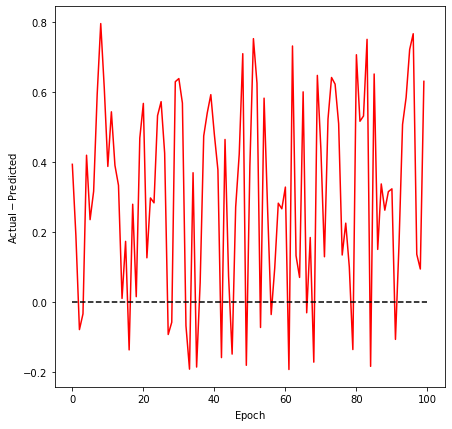

In [87]:
    # Assuming CNN epochs save y_predicted values in order of epoch for each index.
fig=plt.figure(figsize=(7,7))
plt.xlabel(r'${\rm Epoch}$')
plt.ylabel(r'${\rm Actual-Predicted}$')

plt.plot(np.arange(len(y_test)), y_test-y_pred[:,0].detach().numpy(), color='r')
plt.plot([0,100], [0,0], color='k',linestyle='dashed')
 
plt.show()

Variance =  0.08947986666666666
Bias =  0.29913185498483214


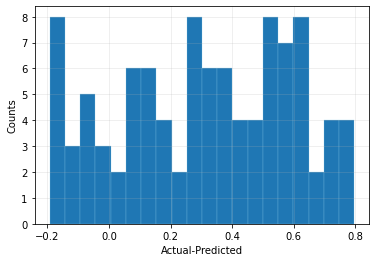

In [86]:
# obtain the bias and variance of the above data:

diff             = y_test - y_pred.detach().numpy()[:,0]
n, bins, patches = plt.hist(diff,density=False,bins=2*round(np.sqrt(len(diff))),edgecolor='skyblue',linewidth=0.25) #
plt.grid(alpha=0.25)
plt.xlabel('Actual-Predicted')
plt.ylabel('Counts')
print("Variance = ", np.var(bins))
print("Bias = ",     np.std(bins))

> ## Nonsense! How can we make this better?

> Our naive construction of a CNN for this setup forces the predictions of $\Omega_m$ to be the exact same value no matter the input image.
> This certainly hits the mark when some portion of the guesses are clustered around the $y=x$ truth line; however, the rest of the time, our network fails spectacularly!

>### Let's re-frame how we approach the CNN.

***

<h2><b>Section 7.</b> New Architecture & Optimization

***

> Let's try mimicking the architecture implemented by the CMD group <span style="color:dodgerblue">[2]</span>!

> First, we understand that to make our data and CNN happy, we start with a single channel. \
> This channel then feeds into a series of convolutional layer blocks which will expand the image in some latent space. Eventually, after roughly 6 passes and a final convolution, we will have reached an output of `128*hiddenx1x1`.

> Finally, we perform `AvgPool2d`, flatten our data, and feed everything into a series of fully-connected network layers.

> At last, we recieve a single value which should reproduce the $\Omega_m$ which we hope to obtain.

In [12]:
torch.manual_seed(123)
class BetterNet(torch.nn.Module):
    def __init__(self, image_size=1,dr=0.2):
        super(BetterNet, self).__init__()
        
            # First pass through of CNN's
            # input: 1x256x256 ---------------> output: 2*hiddenx128x128
        self.C01 = torch.nn.Conv2d(  image_size, 2*image_size, kernel_size=3, padding=1,stride=1,
                            padding_mode='circular', bias=True)
        self.C02 = torch.nn.Conv2d(2*image_size, 2*image_size, kernel_size=3, padding=1,stride=1,
                            padding_mode='circular', bias=True)
        self.C03 = torch.nn.Conv2d(2*image_size, 2*image_size, kernel_size=2, padding=0,stride=2,
                            padding_mode='circular', bias=True)
        self.B01 = torch.nn.BatchNorm2d(2*image_size)
        self.B02 = torch.nn.BatchNorm2d(2*image_size)
        self.B03 = torch.nn.BatchNorm2d(2*image_size)

            # 2nd pass through of CNN's
            # input: 2*hiddenx128x128 ----------> output: 4*hiddenx64x64
        self.C11 = torch.nn.Conv2d(2*image_size, 4*image_size, kernel_size=3, padding=1,stride=1,
                            padding_mode='circular', bias=True)
        self.C12 = torch.nn.Conv2d(4*image_size, 4*image_size, kernel_size=3, padding=1,stride=1,
                            padding_mode='circular', bias=True)
        self.C13 = torch.nn.Conv2d(4*image_size, 4*image_size, kernel_size=2, padding=0,stride=2,
                            padding_mode='circular', bias=True)
        self.B11 = torch.nn.BatchNorm2d(4*image_size)
        self.B12 = torch.nn.BatchNorm2d(4*image_size)
        self.B13 = torch.nn.BatchNorm2d(4*image_size)

            # 3rd pass through of CNN's
            # input: 4*hiddenx64x64 --------> output: 8*hiddenx32x32
        self.C21 = torch.nn.Conv2d(4*image_size, 8*image_size, kernel_size=3, padding=1,stride=1,
                            padding_mode='circular', bias=True)
        self.C22 = torch.nn.Conv2d(8*image_size, 8*image_size, kernel_size=3, padding=1,stride=1,
                            padding_mode='circular', bias=True)
        self.C23 = torch.nn.Conv2d(8*image_size, 8*image_size, kernel_size=2, padding=0,stride=2,
                            padding_mode='circular', bias=True)
        self.B21 = torch.nn.BatchNorm2d(8*image_size)
        self.B22 = torch.nn.BatchNorm2d(8*image_size)
        self.B23 = torch.nn.BatchNorm2d(8*image_size)

            # 4th pass through of CNN's
            # input: 8*hiddenx32x32 ----------> output: 16*hiddenx16x16
        self.C31 = torch.nn.Conv2d(8*image_size, 16*image_size, kernel_size=3, padding=1,stride=1,
                            padding_mode='circular', bias=True)
        self.C32 = torch.nn.Conv2d(16*image_size, 16*image_size, kernel_size=3, padding=1,stride=1,
                            padding_mode='circular', bias=True)
        self.C33 = torch.nn.Conv2d(16*image_size, 16*image_size, kernel_size=2, padding=0,stride=2,
                            padding_mode='circular', bias=True)
        self.B31 = torch.nn.BatchNorm2d(16*image_size)
        self.B32 = torch.nn.BatchNorm2d(16*image_size)
        self.B33 = torch.nn.BatchNorm2d(16*image_size)

            # 5th pass through of CNN's
            # input: 16*hiddenx16x16 ----------> output: 32*hiddenx8x8
        self.C41 = torch.nn.Conv2d(16*image_size, 32*image_size, kernel_size=3, padding=1,stride=1,
                            padding_mode='circular', bias=True)
        self.C42 = torch.nn.Conv2d(32*image_size, 32*image_size, kernel_size=3, padding=1,stride=1,
                            padding_mode='circular', bias=True)
        self.C43 = torch.nn.Conv2d(32*image_size, 32*image_size, kernel_size=2, padding=0,stride=2,
                            padding_mode='circular', bias=True)
        self.B41 = torch.nn.BatchNorm2d(32*image_size)
        self.B42 = torch.nn.BatchNorm2d(32*image_size)
        self.B43 = torch.nn.BatchNorm2d(32*image_size)

            # 6th pass through of CNN's
            # input: 32*hiddenx8x8 ----------> output:64*hiddenx4x4
        self.C51 = torch.nn.Conv2d(32*image_size, 64*image_size, kernel_size=3, padding=1,stride=1,
                            padding_mode='circular', bias=True)
        self.C52 = torch.nn.Conv2d(64*image_size, 64*image_size, kernel_size=3, padding=1,stride=1,
                            padding_mode='circular', bias=True)
        self.C53 = torch.nn.Conv2d(64*image_size, 64*image_size, kernel_size=2, padding=0,stride=2,
                            padding_mode='circular', bias=True)
        self.B51 = torch.nn.BatchNorm2d(64*image_size)
        self.B52 = torch.nn.BatchNorm2d(64*image_size)
        self.B53 = torch.nn.BatchNorm2d(64*image_size)

            # Last CNN layer:
            # input: 64*hiddenx4x4 ----------> output: 128*hiddenx1x1
        self.C61 = torch.nn.Conv2d(64*image_size, 128*image_size, kernel_size=4, padding=0,stride=1)
        self.B61 = torch.nn.BatchNorm2d(128*image_size)



            # pooling:
        self.P0 = nn.AvgPool2d(kernel_size=2,stride=2,padding=0)

            # fully connected layer(s):
        self.fc1 = torch.nn.Linear(image_size*128, image_size*64)
        self.fc2 = torch.nn.Linear(image_size*64, 1) # want a single parameter estimated.

            # dropout and activations:
        self.dropout   = torch.nn.Dropout(p=dr)
        self.ReLU      = nn.ReLU()
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.tanh      = nn.Tanh()

        for m in self.modules():
            if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)



        # x represents our data
    def forward(self, x):

        x = self.LeakyReLU(self.B01(self.C01(x)))
        x = self.LeakyReLU(self.B02(self.C02(x)))
        x = self.LeakyReLU(self.B03(self.C03(x)))

        x = self.LeakyReLU(self.B11(self.C11(x)))
        x = self.LeakyReLU(self.B12(self.C12(x)))
        x = self.LeakyReLU(self.B13(self.C13(x)))

        x = self.LeakyReLU(self.B21(self.C21(x)))
        x = self.LeakyReLU(self.B22(self.C22(x)))
        x = self.LeakyReLU(self.B23(self.C23(x)))

        x = self.LeakyReLU(self.B31(self.C31(x)))
        x = self.LeakyReLU(self.B32(self.C32(x)))
        x = self.LeakyReLU(self.B33(self.C33(x)))

        x = self.LeakyReLU(self.B41(self.C41(x)))
        x = self.LeakyReLU(self.B42(self.C42(x)))
        x = self.LeakyReLU(self.B43(self.C43(x)))

        x = self.LeakyReLU(self.B51(self.C51(x)))
        x = self.LeakyReLU(self.B52(self.C52(x)))
        x = self.LeakyReLU(self.B53(self.C53(x)))

        x = self.LeakyReLU(self.B61(self.C61(x)))
            # linked blocks for CNN are done.

        x = F.adaptive_avg_pool2d(x,(1,1))
            # pooling.
    
            # Flatten x with start_dim=1, i.e. only keep one number per channel per event.
        x=torch.flatten(x,1) # (input, start_dim (first dim to flatten))

        # x = x.view(image.shape[0],-1)
        
        # x = self.P0(x)
        x = self.dropout(x)
        x = self.dropout(self.LeakyReLU(self.fc1(x)))
        x = self.fc2(x)

        return x

>### Awesome, now for putting theory into practice:

In [13]:
    # create the net, define the loss fuction and optimizer
net = BetterNet(dr=0.6)
    # let's set the dropout rate fairly high as to prevent overtraining.


print(net)
print(np.sum([np.prod(theta.shape) for theta in net.parameters()]))

lr = 1e-2   # quite a bit smaller, more typical.
wd=0.0005   # some weight decay.
beta1=0.5   # coefficients used for computing running averages of gradient
beta2=0.999 # ...

# optimizer = torch.optim.SGD(net.parameters(), lr=0.5, momentum=0.9,weight_decay=1e-5)
optimizer = torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=wd, betas=(beta1, beta2))
    # let's use another optimizer as well :-)
loss_fn = torch.nn.MSELoss()

BetterNet(
  (C01): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (C02): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (C03): Conv2d(2, 2, kernel_size=(2, 2), stride=(2, 2), padding_mode=circular)
  (B01): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (B02): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (B03): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (C11): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (C12): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (C13): Conv2d(4, 4, kernel_size=(2, 2), stride=(2, 2), padding_mode=circular)
  (B11): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (B12): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (B1

In [14]:
net.train()
losses = []
losses_test = []

loader = torch.utils.data.DataLoader(xy_train, batch_size=10, shuffle=True)
    # increase batch size slightly to help with computation time.

for epoch in tqdm(range(300)):
    start_time = time.time()
    for x_batch, y_batch in loader:
        # print(x_batch)
        y_pred = net(x_batch)
        optimizer.zero_grad()
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    losses.append(loss.data)
    net.eval() # configure the model for evaluation (testing)
    y_pred = net(x_test_tensor)
    test_loss=loss_fn(y_pred, y_test_tensor)
    losses_test.append(test_loss.data)
    end_time=time.time()
    elapsed_time = end_time - start_time
    # print("Completed epoch %2d in %4.1fs, Train loss=%4.1e, Test loss=%4.2e" % (epoch, elapsed_time, loss.data, test_loss.data))

100%|██████████| 300/300 [24:39<00:00,  4.93s/it]


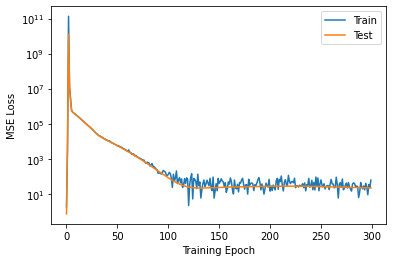

In [15]:
plt.plot(losses, label="Train")
plt.plot(losses_test, label="Test")
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('MSE Loss')
plt.yscale('log');

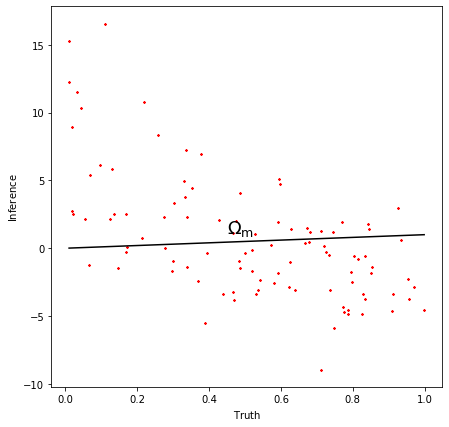

In [17]:
    # create an inference vs. truth plot.
fig=plt.figure(figsize=(7,7))
plt.xlabel(r'${\rm Truth}$')
plt.ylabel(r'${\rm Inference}$')
# plt.ylim(0,1)
plt.text(0.45, max(y_test)+0.10, r'$\Omega_{\rm m}$',fontsize=18)

    # compare predicted values with the y_test values!
plt.scatter(y_test, y_pred[:,0].detach().numpy(), color='r',marker='x',s=3)
plt.plot([min(y_test),max(y_test)], [min(y_test),max(y_test)], color='k')
 
plt.show()

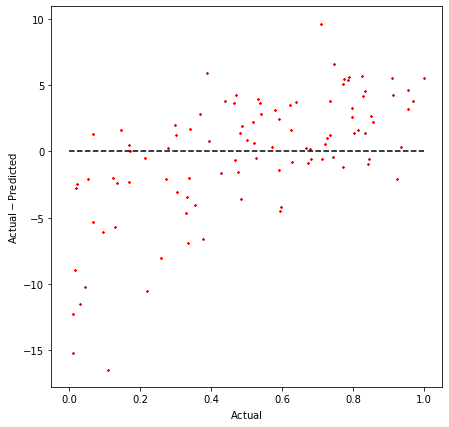

In [18]:
    # create an inference vs. truth plot.
fig=plt.figure(figsize=(7,7))
plt.xlabel(r'${\rm Actual}$')
plt.ylabel(r'${\rm Actual-Predicted}$')

    # compare predicted values with the y_test values!
plt.scatter(y_test, (y_test - y_pred.detach().numpy()[:,0]), color='r',marker='x',s=3)
plt.plot([0,1], [0,0], 'k--')
 
plt.show()

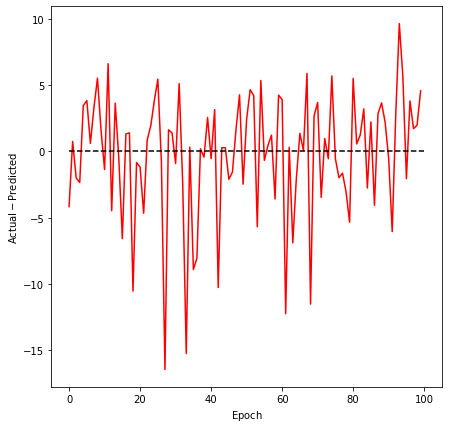

In [19]:
    # Assuming CNN epochs save y_predicted values in order of epoch for each index.
fig=plt.figure(figsize=(7,7))
plt.xlabel(r'${\rm Epoch}$')
plt.ylabel(r'${\rm Actual-Predicted}$')

plt.plot(np.arange(len(y_test)), y_test-y_pred[:,0].detach().numpy(), color='r')
plt.plot([0,100], [0,0], color='k',linestyle='dashed')
 
plt.show()

Variance =  62.403401174800365
Bias =  7.899582341795063


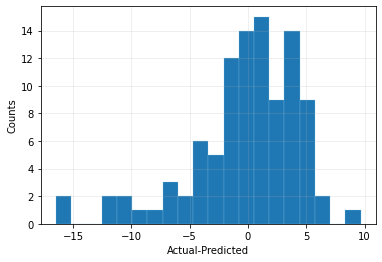

In [20]:
# obtain the bias and variance of the above data:

diff             = y_test - y_pred.detach().numpy()[:,0]
n, bins, patches = plt.hist(diff,density=False,bins=2*round(np.sqrt(len(diff))),edgecolor='skyblue',linewidth=0.25) #
plt.grid(alpha=0.25)
plt.xlabel('Actual-Predicted')
plt.ylabel('Counts')
print("Variance = ", np.var(bins))
print("Bias = ",     np.std(bins))

> # They're beginning to <i>believe!
> (The network is starting to learn properly).

> Let's do some basic hyperparameter optimization now that the architecture is much better.

> To start, we'll significantly decrease the amount of epochs we train over for the sake of time.

## Learning Rate Optimization

In [33]:
net = BetterNet(dr=0.6)

lr = [1e-5,1e-4,1e-3,1e-2,1e-1]
wd=0.0005   
beta1=0.5   
beta2=0.999 

loss_fn = torch.nn.MSELoss()

In [34]:
optim_losses      = []
optim_losses_test = []

for learning_rate in lr:
    net.train()
    losses = []
    losses_test = []

    optimizer = torch.optim.AdamW(net.parameters(), lr=learning_rate, weight_decay=wd, betas=(beta1, beta2))
    loader = torch.utils.data.DataLoader(xy_train, batch_size=10, shuffle=True)
        # increase batch size slightly to help with computation time.

    for epoch in tqdm(range(10)):
        start_time = time.time()
        for x_batch, y_batch in loader:
            # print(x_batch)
            y_pred = net(x_batch)
            optimizer.zero_grad()
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
        losses.append(loss.data)
        net.eval() # configure the model for evaluation (testing)
        y_pred = net(x_test_tensor)
        test_loss=loss_fn(y_pred, y_test_tensor)
        losses_test.append(test_loss.data)
        end_time=time.time()
        elapsed_time = end_time - start_time
        # print("Completed epoch %2d in %4.1fs, Train loss=%4.1e, Test loss=%4.2e" % (epoch, elapsed_time, loss.data, test_loss.data))

    optim_losses.append(losses)
    optim_losses_test.append(losses_test)

100%|██████████| 10/10 [00:46<00:00,  4.62s/it]


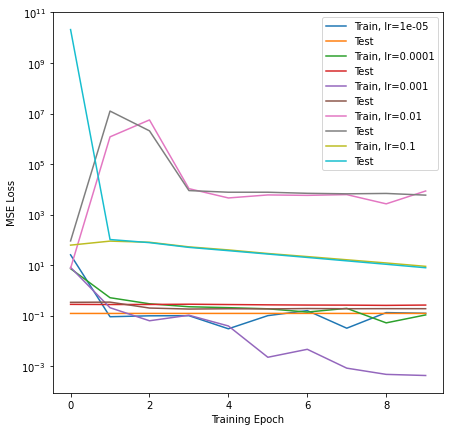

In [42]:
fig=plt.figure(figsize=(7,7))
for i,losses in enumerate(optim_losses):
    train_s = "Train, lr=" + str(lr[i])
    plt.plot(optim_losses[i], label=train_s)
    plt.plot(optim_losses_test[i], label="Test")
    plt.legend()
    plt.xlabel('Training Epoch')
    plt.ylabel('MSE Loss')
    plt.yscale('log');

## Weight Decay Optimization

In [55]:
net = BetterNet(dr=0.6)

lr = 0.001 # seems to be a good value from above.
wd = [0.00001,0.0005,0.001,0.01,0.1]
beta1=0.5   
beta2=0.999 

loss_fn = torch.nn.MSELoss()

In [56]:
optim_losses      = []
optim_losses_test = []

for weight_decay in wd:
    net.train()
    losses = []
    losses_test = []

    optimizer = torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=weight_decay, betas=(beta1, beta2))
    loader = torch.utils.data.DataLoader(xy_train, batch_size=10, shuffle=True)
        # increase batch size slightly to help with computation time.

    for epoch in tqdm(range(10)):
        start_time = time.time()
        for x_batch, y_batch in loader:
            # print(x_batch)
            y_pred = net(x_batch)
            optimizer.zero_grad()
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
        losses.append(loss.data)
        net.eval() # configure the model for evaluation (testing)
        y_pred = net(x_test_tensor)
        test_loss=loss_fn(y_pred, y_test_tensor)
        losses_test.append(test_loss.data)
        end_time=time.time()
        elapsed_time = end_time - start_time
        # print("Completed epoch %2d in %4.1fs, Train loss=%4.1e, Test loss=%4.2e" % (epoch, elapsed_time, loss.data, test_loss.data))

    optim_losses.append(losses)
    optim_losses_test.append(losses_test)

100%|██████████| 10/10 [00:46<00:00,  4.69s/it]


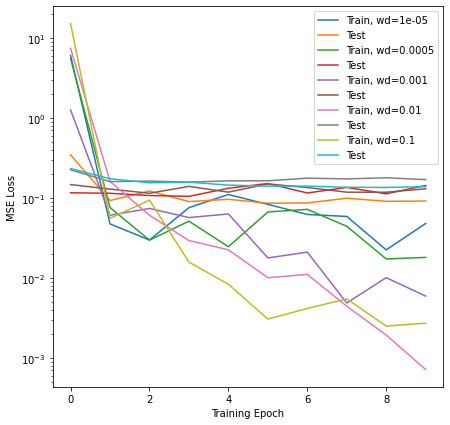

In [57]:
fig=plt.figure(figsize=(7,7))
for i,losses in enumerate(optim_losses):
    train_s = "Train, wd=" + str(wd[i])
    plt.plot(optim_losses[i], label=train_s)
    plt.plot(optim_losses_test[i], label="Test")
    plt.legend()
    plt.xlabel('Training Epoch')
    plt.ylabel('MSE Loss')
    plt.yscale('log');

## $\beta_1$ Optimization

In [58]:
net = BetterNet(dr=0.6)

lr    = 0.001
wd    = 0.01  # seems to be a good value from above.
beta1 = [0.01,0.1,0.25,0.5,0.9]
beta2 = 0.999 

loss_fn = torch.nn.MSELoss()

In [59]:
optim_losses      = []
optim_losses_test = []

for b1 in beta1:
    net.train()
    losses = []
    losses_test = []

    optimizer = torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=wd, betas=(b1, beta2))
    loader = torch.utils.data.DataLoader(xy_train, batch_size=10, shuffle=True)
        # increase batch size slightly to help with computation time.

    for epoch in tqdm(range(15)):
        start_time = time.time()
        for x_batch, y_batch in loader:
            # print(x_batch)
            y_pred = net(x_batch)
            optimizer.zero_grad()
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
        losses.append(loss.data)
        net.eval() # configure the model for evaluation (testing)
        y_pred = net(x_test_tensor)
        test_loss=loss_fn(y_pred, y_test_tensor)
        losses_test.append(test_loss.data)
        end_time=time.time()
        elapsed_time = end_time - start_time
        # print("Completed epoch %2d in %4.1fs, Train loss=%4.1e, Test loss=%4.2e" % (epoch, elapsed_time, loss.data, test_loss.data))

    optim_losses.append(losses)
    optim_losses_test.append(losses_test)

100%|██████████| 15/15 [01:10<00:00,  4.70s/it]


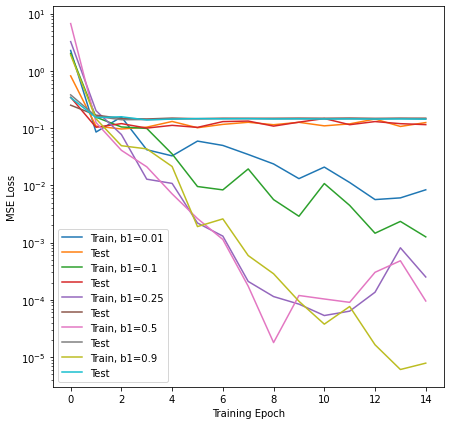

In [60]:
fig=plt.figure(figsize=(7,7))
for i,losses in enumerate(optim_losses):
    train_s = "Train, b1=" + str(beta1[i])
    plt.plot(optim_losses[i], label=train_s)
    plt.plot(optim_losses_test[i], label="Test")
    plt.legend()
    plt.xlabel('Training Epoch')
    plt.ylabel('MSE Loss')
    plt.yscale('log');

## $\beta_2$ Optimization

In [61]:
net = BetterNet(dr=0.6)

lr    = 0.001
wd    = 0.01
beta1 = 0.9   # seems to be a good value from above.
beta2 = [0.01,0.1,0.5,0.9,0.999]

loss_fn = torch.nn.MSELoss()

In [63]:
optim_losses      = []
optim_losses_test = []

for b2 in beta2:
    net.train()
    losses = []
    losses_test = []

    optimizer = torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=wd, betas=(beta1, b2))
    loader = torch.utils.data.DataLoader(xy_train, batch_size=10, shuffle=True)
        # increase batch size slightly to help with computation time.

    for epoch in tqdm(range(15)):
        start_time = time.time()
        for x_batch, y_batch in loader:
            # print(x_batch)
            y_pred = net(x_batch)
            optimizer.zero_grad()
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
        losses.append(loss.data)
        net.eval() # configure the model for evaluation (testing)
        y_pred = net(x_test_tensor)
        test_loss=loss_fn(y_pred, y_test_tensor)
        losses_test.append(test_loss.data)
        end_time=time.time()
        elapsed_time = end_time - start_time
        # print("Completed epoch %2d in %4.1fs, Train loss=%4.1e, Test loss=%4.2e" % (epoch, elapsed_time, loss.data, test_loss.data))

    optim_losses.append(losses)
    optim_losses_test.append(losses_test)

100%|██████████| 15/15 [01:11<00:00,  4.75s/it]


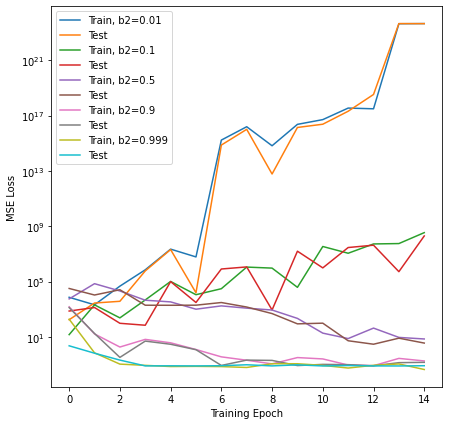

In [67]:
fig=plt.figure(figsize=(7,7))
for i,losses in enumerate(optim_losses):
    train_s = "Train, b2=" + str(beta2[i])
    plt.plot(optim_losses[i], label=train_s)
    plt.plot(optim_losses_test[i], label="Test")
    plt.legend()
    plt.xlabel('Training Epoch')
    plt.ylabel('MSE Loss')
    plt.yscale('log');

## Dropout Optimization

In [68]:
dropout = [0.1,0.3,0.6,0.8,0.9]

lr    = 0.001
wd    = 0.01
beta1 = 0.9
beta2 = 0.999 # seems to be a good value from above.

loss_fn = torch.nn.MSELoss()

In [72]:
optim_losses      = []
optim_losses_test = []

for dr in dropout:
    net = BetterNet(dr=dr)
    net.train()
    losses = []
    losses_test = []

    optimizer = torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=wd, betas=(beta1, beta2))
    loader = torch.utils.data.DataLoader(xy_train, batch_size=10, shuffle=True)
        # increase batch size slightly to help with computation time.

    for epoch in tqdm(range(15)):
        start_time = time.time()
        for x_batch, y_batch in loader:
            # print(x_batch)
            y_pred = net(x_batch)
            optimizer.zero_grad()
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
        losses.append(loss.data)
        net.eval() # configure the model for evaluation (testing)
        y_pred = net(x_test_tensor)
        test_loss=loss_fn(y_pred, y_test_tensor)
        losses_test.append(test_loss.data)
        end_time=time.time()
        elapsed_time = end_time - start_time
        # print("Completed epoch %2d in %4.1fs, Train loss=%4.1e, Test loss=%4.2e" % (epoch, elapsed_time, loss.data, test_loss.data))

    optim_losses.append(losses)
    optim_losses_test.append(losses_test)

100%|██████████| 15/15 [01:13<00:00,  4.89s/it]


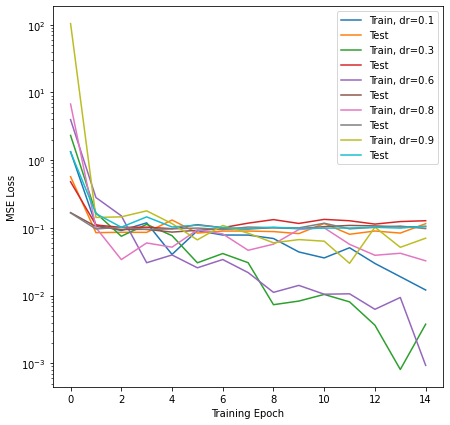

In [75]:
fig=plt.figure(figsize=(7,7))
for i,losses in enumerate(optim_losses):
    train_s = "Train, dr=" + str(dropout[i])
    plt.plot(optim_losses[i], label=train_s)
    plt.plot(optim_losses_test[i], label="Test")
    plt.legend()
    plt.xlabel('Training Epoch')
    plt.ylabel('MSE Loss')
    plt.yscale('log');
    # plt.show()

## Batch Size Optimization

In [80]:
net = BetterNet(dr=0.9) # seems to be a good value from above.

lr    = 0.001
wd    = 0.01
beta1 = 0.9
beta2 = 0.999

batch_sizes = [2,5,10,20,50]

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=wd, betas=(beta1, beta2))

In [81]:
optim_losses      = []
optim_losses_test = []

for bs in batch_sizes:
    net.train()
    losses = []
    losses_test = []

    loader = torch.utils.data.DataLoader(xy_train, batch_size=bs, shuffle=True)
        # increase batch size slightly to help with computation time.

    for epoch in tqdm(range(15)):
        start_time = time.time()
        for x_batch, y_batch in loader:
            # print(x_batch)
            y_pred = net(x_batch)
            optimizer.zero_grad()
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
        losses.append(loss.data)
        net.eval() # configure the model for evaluation (testing)
        y_pred = net(x_test_tensor)
        test_loss=loss_fn(y_pred, y_test_tensor)
        losses_test.append(test_loss.data)
        end_time=time.time()
        elapsed_time = end_time - start_time
        # print("Completed epoch %2d in %4.1fs, Train loss=%4.1e, Test loss=%4.2e" % (epoch, elapsed_time, loss.data, test_loss.data))

    optim_losses.append(losses)
    optim_losses_test.append(losses_test)

100%|██████████| 15/15 [00:59<00:00,  3.97s/it]


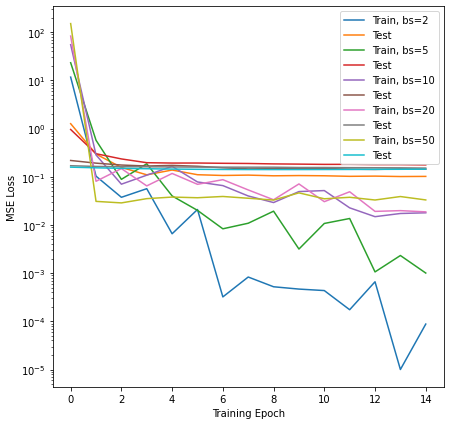

In [84]:
fig=plt.figure(figsize=(7,7))
for i,losses in enumerate(optim_losses):
    train_s = "Train, bs=" + str(batch_sizes[i])
    plt.plot(optim_losses[i], label=train_s)
    plt.plot(optim_losses_test[i], label="Test")
    plt.legend()
    plt.xlabel('Training Epoch')
    plt.ylabel('MSE Loss')
    plt.yscale('log');
    # plt.show()

## Cool! Now let's train on the best set of hyperparameters.

In [86]:
net = BetterNet(dr=0.9)

# print(net)
print(np.sum([np.prod(theta.shape) for theta in net.parameters()]))

lr    = 0.001
wd    = 0.01
beta1 = 0.9
beta2 = 0.999

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=wd, betas=(beta1, beta2))

236461


In [87]:
net.train()
losses = []
losses_test = []

loader = torch.utils.data.DataLoader(xy_train, batch_size=5, shuffle=True)
    # set batch size to a good value from above.

for epoch in tqdm(range(300)):
    start_time = time.time()
    for x_batch, y_batch in loader:
        # print(x_batch)
        y_pred = net(x_batch)
        optimizer.zero_grad()
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    losses.append(loss.data)
    net.eval() # configure the model for evaluation (testing)
    y_pred = net(x_test_tensor)
    test_loss=loss_fn(y_pred, y_test_tensor)
    losses_test.append(test_loss.data)
    end_time=time.time()
    elapsed_time = end_time - start_time
    # print("Completed epoch %2d in %4.1fs, Train loss=%4.1e, Test loss=%4.2e" % (epoch, elapsed_time, loss.data, test_loss.data))

100%|██████████| 300/300 [25:28<00:00,  5.09s/it]


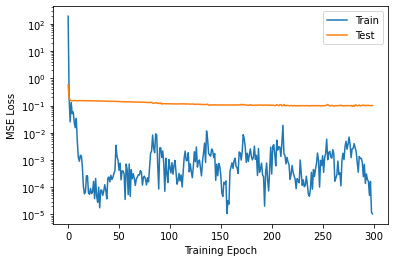

In [89]:
plt.plot(losses, label="Train")
plt.plot(losses_test, label="Test")
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('MSE Loss')
plt.yscale('log');

>## Wow, lots of overtraining here. Further adjustment is needed.

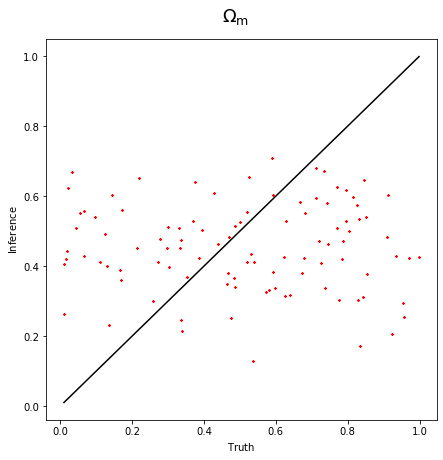

In [97]:
    # create an inference vs. truth plot.
fig=plt.figure(figsize=(7,7))
plt.xlabel(r'${\rm Truth}$')
plt.ylabel(r'${\rm Inference}$')
# plt.ylim(0,1)
plt.text(0.45, max(y_test)+0.10, r'$\Omega_{\rm m}$',fontsize=18)

    # compare predicted values with the y_test values!
plt.scatter(y_test, y_pred[:,0].detach().numpy(), color='r',marker='x',s=3)
plt.plot([min(y_test),max(y_test)], [min(y_test),max(y_test)], color='k')
 
plt.show()

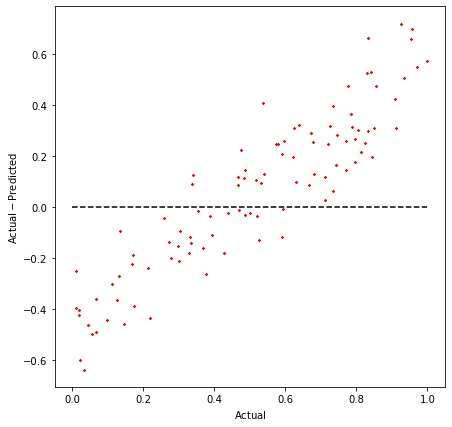

In [91]:
    # create an inference vs. truth plot.
fig=plt.figure(figsize=(7,7))
plt.xlabel(r'${\rm Actual}$')
plt.ylabel(r'${\rm Actual-Predicted}$')

    # compare predicted values with the y_test values!
plt.scatter(y_test, (y_test - y_pred.detach().numpy()[:,0]), color='r',marker='x',s=3)
plt.plot([0,1], [0,0], 'k--')
 
plt.show()

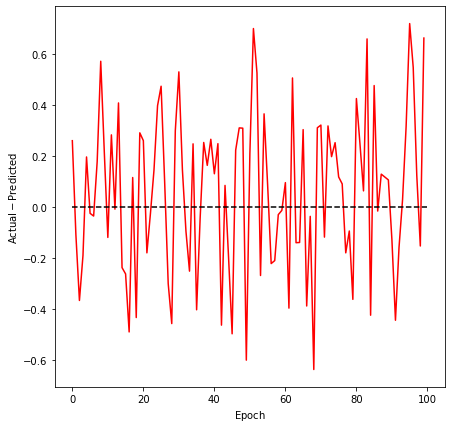

In [92]:
    # Assuming CNN epochs save y_predicted values in order of epoch for each index.
fig=plt.figure(figsize=(7,7))
plt.xlabel(r'${\rm Epoch}$')
plt.ylabel(r'${\rm Actual-Predicted}$')

plt.plot(np.arange(len(y_test)), y_test-y_pred[:,0].detach().numpy(), color='r')
plt.plot([0,100], [0,0], color='k',linestyle='dashed')
 
plt.show()

Variance =  0.16879776081267048
Bias =  0.41085004662610236


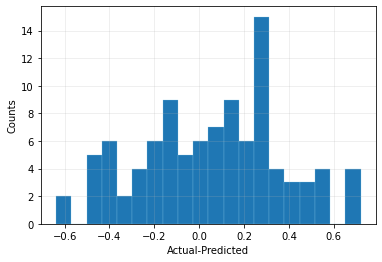

In [93]:
# obtain the bias and variance of the above data:

diff             = y_test - y_pred.detach().numpy()[:,0]
n, bins, patches = plt.hist(diff,density=False,bins=2*round(np.sqrt(len(diff))),edgecolor='skyblue',linewidth=0.25) #
plt.grid(alpha=0.25)
plt.xlabel('Actual-Predicted')
plt.ylabel('Counts')
print("Variance = ", np.var(bins))
print("Bias = ",     np.std(bins))

***

<h2><b>Section 8.</b> Discussion

***

> ### Looks like we didn't get things quite up to par.
### There's likely a couple of reasons for this:

>- <b>CNN Architecture</b>: We could have incoporated a more complex structure, had more dropout, different implimentation of pooling, messed with stride, padding, etc.

>- <b>Hyperparameters</b>: Although we scanned through the hyperparameters we use, we could have increased the number of epochs trained over, and gone back through once more (since some parameters may affect others is non-trivial ways).

>- <b>Image Data</b>: We only included two fields from the SIMBA dataset. We could have incoroporated many more, included more than just 100 images for training and testing, etc. Even rotating/mirroring images to create new input data would immensely help the network train.

>- <b>Training time</b>: Due to time and computational constraints, we only ran for so much time before deciding to stop the network from continuing to train.

Given more time, I would expand our inquiry to all fields available, run the network on the entirety of the image dataset, etc. In this way, the CNN we've created would be able to thrive, rather than starving it of crucial information and input in exchange for a lower wall time.

***

### Once again, thank you so much, Mike, for providing this wonderful course for us.
### I'm very glad I had the opportunity to take this before graduating, I truly appreciate all that you've done ❤️

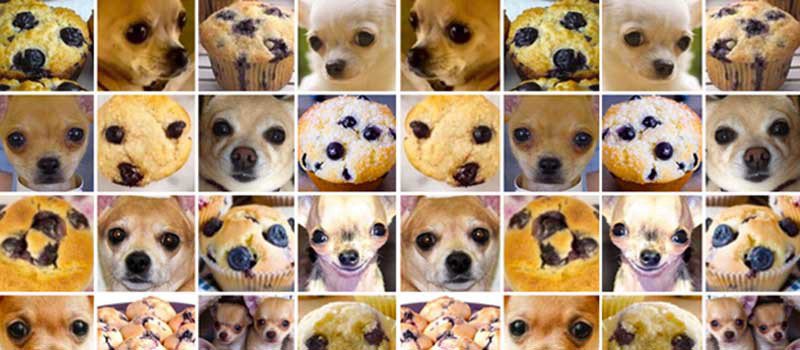

In [96]:
from PIL import Image
import requests
from io import BytesIO

response = requests.get('https://cdn-media-1.freecodecamp.org/images/1*bt-E2YcPafjiPbZFDMMmNQ.jpeg')
img = Image.open(BytesIO(response.content))
img
